In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Define data transform
transform = transforms.Compose([
        transforms.ToTensor(),
])

# Create training and validation split of data
train_split_all = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Limit amount of training data
N = 1500
indices = torch.randperm(len(train_split_all))[:N]
train_split = Subset(train_split_all, indices)
test_split = datasets.MNIST('./data', train=False, download=True, transform=transform)

# create dataloaders for train and test splits
train_dataloader = DataLoader(train_split, shuffle=True, batch_size=50, num_workers=1)
test_dataloader = DataLoader(test_split, shuffle=False, batch_size=50, num_workers=1)

0 torch.Size([50, 1, 28, 28]) torch.Size([50])
tensor(1.)


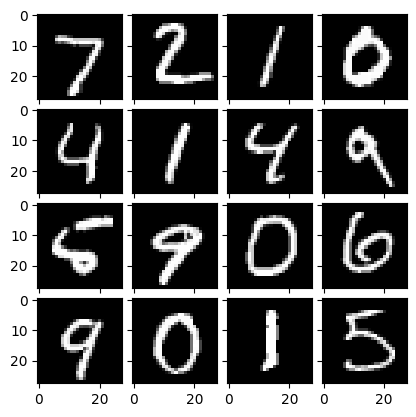

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# get batch from dataloader
sampler = enumerate(test_dataloader)
batch_idx, (x, y) = next(sampler)
print(batch_idx, x.shape, y.shape)

# select sample images
images = [x[i].squeeze().numpy() for i in range(16)]
print(x.max())

# create and display plot
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
)
for axis, image in zip(grid, images):
    # Iterating over the grid returns the Axes.
    axis.imshow(image, cmap='gray')

plt.show() 

# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [47]:
import torch
import torch.nn as nn # shift+enter

# define model using torch.nn
class MLP(nn.Module):
  def __init__(self, input_size=28*28, hidden_size=32, output_size=10):
    super(MLP, self).__init__()

    # define layers
    self.layer_1 = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.layer_2 = nn.Linear(in_features=hidden_size, out_features=output_size)

    # define activations
    self.act = nn.Sigmoid()
    self.tanh = nn.Tanh()


  def forward(self, x):
    x = torch.flatten(x, start_dim=1, end_dim=-1)
    
    h_1 = self.layer_1(x)
    a_1 = self.tanh(h_1)

    h_2 = self.layer_2(a_1)
    y = self.act(h_2)

    return y

# (one hot encoding)
# 0 : [1, 0, 0, 0, 0, 0, ....]
# 1 : [0, 1, 0, 0, 0, 0, ....]
# 2 : [0, 0, 1, 0, 0, 0 ....]

# 2 classes, cats and dogs
# Cats : [1, 0]
# Dogs : [0, 1]

In [48]:
import torch.optim as optim
from torch.nn.functional import one_hot

# hyperparameters
num_epochs = 100
lr = 1

# create model, optimizer, and loss function
model = MLP(input_size=28*28, hidden_size=8, output_size=10).to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr)
mse_loss = nn.MSELoss() # 1/N * sum((pred - y)**2)

# define the training and test steps
def train(model, optimizer, dataloader):
  model.train()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()

    pred = model(x)
    loss = mse_loss(pred, one_hot(y, num_classes=10).float())
    loss.backward()
    optimizer.step()

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

def test(model, dataloader):
  model.eval()
  losses = []
  accuracies = []

  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')

    pred = model(x)
    loss = mse_loss(pred, one_hot(y, num_classes=10).float())

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, test_dataloader)

  print(f'{epoch}: Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

0: Train loss: 0.08, Train Accuracy: 0.36, Test loss: 0.07, Test Accuracy: 0.41
1: Train loss: 0.06, Train Accuracy: 0.55, Test loss: 0.06, Test Accuracy: 0.63
2: Train loss: 0.05, Train Accuracy: 0.67, Test loss: 0.05, Test Accuracy: 0.69
3: Train loss: 0.04, Train Accuracy: 0.72, Test loss: 0.04, Test Accuracy: 0.75
4: Train loss: 0.04, Train Accuracy: 0.79, Test loss: 0.04, Test Accuracy: 0.82
5: Train loss: 0.03, Train Accuracy: 0.83, Test loss: 0.03, Test Accuracy: 0.84
6: Train loss: 0.03, Train Accuracy: 0.85, Test loss: 0.03, Test Accuracy: 0.85
7: Train loss: 0.03, Train Accuracy: 0.86, Test loss: 0.03, Test Accuracy: 0.86
8: Train loss: 0.03, Train Accuracy: 0.86, Test loss: 0.03, Test Accuracy: 0.86
9: Train loss: 0.03, Train Accuracy: 0.87, Test loss: 0.02, Test Accuracy: 0.87
10: Train loss: 0.02, Train Accuracy: 0.87, Test loss: 0.02, Test Accuracy: 0.87
11: Train loss: 0.02, Train Accuracy: 0.87, Test loss: 0.02, Test Accuracy: 0.87


KeyboardInterrupt: 

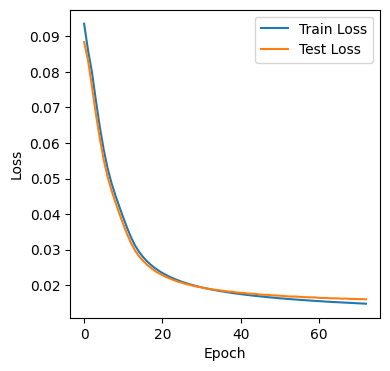

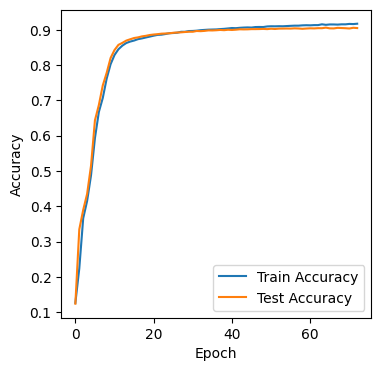

In [46]:
# plot loss and accuracy
plt.figure(figsize=(4, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

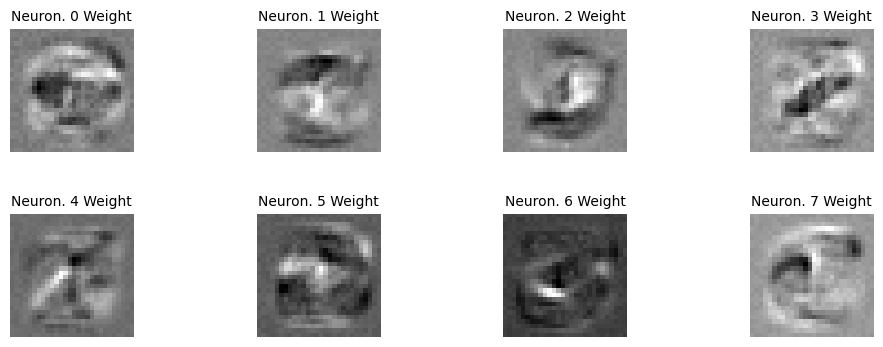

In [164]:
import matplotlib.pyplot as plt

# visualize weights of first layer
images = [model.layer_1.weight[i, :].detach().reshape(28, 28).cpu().numpy() for i in range(model.layer_1.weight.shape[0])]

# Set up grid
n_rows, n_cols = 2, model.layer_1.weight.shape[0]//2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4))  # Bigger figsize helps spacing
axes = axes.flatten()

for i, (ax, image) in enumerate(zip(axes, images)):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Neuron. {i} Weight', fontsize=10)
    ax.axis('off')  # Hide axes ticks

# Adjust spacing between plots and titles
plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()


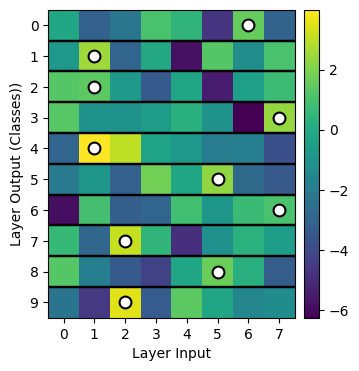

torch.Size([10, 8])


In [165]:
import matplotlib.pyplot as plt

# Get the weight matrix
weights = model.layer_2.weight.detach().cpu()

fig = plt.figure(figsize=(6, 4))
im = plt.imshow(weights, aspect='equal')

plt.xticks(ticks=range(weights.shape[1]))
plt.yticks(ticks=range(weights.shape[0])) # number of classes

# Draw horizontal lines between rows
for y in range(1, weights.shape[0]):
    plt.axhline(y - 0.5, color='black', linewidth=1.75)

for y, row in enumerate(weights):
    x = row.argmax().item()
    plt.plot(x, y, marker='o', color='black', markersize=9)
    plt.plot(x, y, marker='o', color='white', markersize=6)
    # x = row.argmin().item()
    # plt.plot(x, y, marker='o', color='black', markersize=9)
    # plt.plot(x, y, marker='o', color='black', markersize=6)
    # x = np.abs(row).argmin().item()
    # plt.plot(x, y, marker='o', color='black', markersize=9)
    # plt.plot(x, y, marker='o', color='gray', markersize=6)

plt.colorbar(im, shrink=1, pad=0.02)
plt.ylabel('Layer Output (Classes))')
plt.xlabel('Layer Input')
plt.show()

print(weights.shape)